ResNet 구현 및 데이터 전처리

실습 1: ResNet 기본 블록 구현

1.1 기본 Residual Block 구현

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
import seaborn as sns
from scipy import stats

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")


Using device: cuda
GPU: NVIDIA GeForce RTX 3060
GPU Memory: 12.0 GB


In [3]:
class BasicBlock(nn.Module):
    """
    ResNet의 기본 블록 (ResNet-18, ResNet-34에서 사용)
    """
    expansion = 1  # 출력 채널이 입력 채널의 몇 배인지
    
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        
        # 첫 번째 3x3 convolution
        self.conv1 = nn.Conv2d(in_channels, out_channels, 
                              kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        # 두 번째 3x3 convolution
        self.conv2 = nn.Conv2d(out_channels, out_channels, 
                              kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Skip connection을 위한 downsampling
        self.downsample = downsample
        self.stride = stride
        
    def forward(self, x):
        # Skip connection을 위해 입력 저장
        identity = x
        
        # Main path: Conv1 -> BN -> ReLU -> Conv2 -> BN
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        # Skip connection 처리
        if self.downsample is not None:
            identity = self.downsample(x)
        
        # Residual connection: F(x) + x
        out += identity
        out = F.relu(out)
        
        return out

In [6]:
def test_basic_block():
    # 입력 텐서 생성 (batch_size=2, channels=64, height=32, width=32)
    x = torch.randn(2, 64, 32, 32).to(device)
    
    # 기본 블록 (채널 수 변화 없음)
    block1 = BasicBlock(64, 64).to(device)
    out1 = block1(x)
    print(f"Input shape: {x.shape}")
    print(f"Output shape (same channels): {out1.shape}")
    
    # 채널 수 변화가 있는 블록
    downsample = nn.Sequential(
        nn.Conv2d(64, 128, kernel_size=1, stride=2, bias=False),
        nn.BatchNorm2d(128)
    ).to(device)
    block2 = BasicBlock(64, 128, stride=2, downsample=downsample).to(device)
    out2 = block2(x)
    print(f"Output shape (channel increase): {out2.shape}")

test_basic_block()

Input shape: torch.Size([2, 64, 32, 32])
Output shape (same channels): torch.Size([2, 64, 32, 32])
Output shape (channel increase): torch.Size([2, 128, 16, 16])


1.2 전체 ResNet-18 구현

In [7]:
class ResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18, self).__init__()
        self.in_channels = 64
        
        # 초기 convolution layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # Residual layers
        self.layer1 = self._make_layer(BasicBlock, 64, 2, stride=1)   # conv2_x
        self.layer2 = self._make_layer(BasicBlock, 128, 2, stride=2)  # conv3_x  
        self.layer3 = self._make_layer(BasicBlock, 256, 2, stride=2)  # conv4_x
        self.layer4 = self._make_layer(BasicBlock, 512, 2, stride=2)  # conv5_x
        
        # 분류기
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * BasicBlock.expansion, num_classes)
        
        # 가중치 초기화
        self._initialize_weights()
    
    def _make_layer(self, block, out_channels, blocks, stride=1):
        """
        Residual layer 생성
        Args:
            block: BasicBlock 클래스
            out_channels: 출력 채널 수
            blocks: 블록의 개수
            stride: 첫 번째 블록의 stride
        """
        downsample = None
        
        # 채널 수나 spatial size가 변하는 경우 downsample 필요
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion,
                         kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion)
            )
        
        layers = []
        # 첫 번째 블록 (stride와 downsample 적용)
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        
        # 나머지 블록들 (stride=1)
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))
        
        return nn.Sequential(*layers)
    
    def _initialize_weights(self):
        """He 초기화 적용"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        # 초기 처리
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.maxpool(x)
        
        # Residual layers
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        # 분류
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        
        return x

In [8]:
def test_resnet18():
    model = ResNet18(num_classes=10).to(device)
    x = torch.randn(4, 3, 224, 224).to(device)  # CIFAR-10 크기로 조정 시 (4, 3, 32, 32)
    
    print("ResNet-18 Architecture:")
    print(f"Input shape: {x.shape}")
    
    # Forward pass
    output = model(x)
    print(f"Output shape: {output.shape}")
    
    # 파라미터 수 계산
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")

test_resnet18()

ResNet-18 Architecture:
Input shape: torch.Size([4, 3, 224, 224])
Output shape: torch.Size([4, 10])
Total parameters: 11,181,642
Trainable parameters: 11,181,642


실습 2: 데이터 전처리와 통계적 근거

2.1 이미지 정규화의 통계적 효과

Files already downloaded and verified
Files already downloaded and verified
Red Channel:
  Raw - Mean: 0.4903, Std: 0.2457
  Normalized - Mean: 0.0233, Std: 1.0727
Green Channel:
  Raw - Mean: 0.4829, Std: 0.2429
  Normalized - Mean: 0.1199, Std: 1.0845
Blue Channel:
  Raw - Mean: 0.4455, Std: 0.2619
  Normalized - Mean: 0.1756, Std: 1.1642


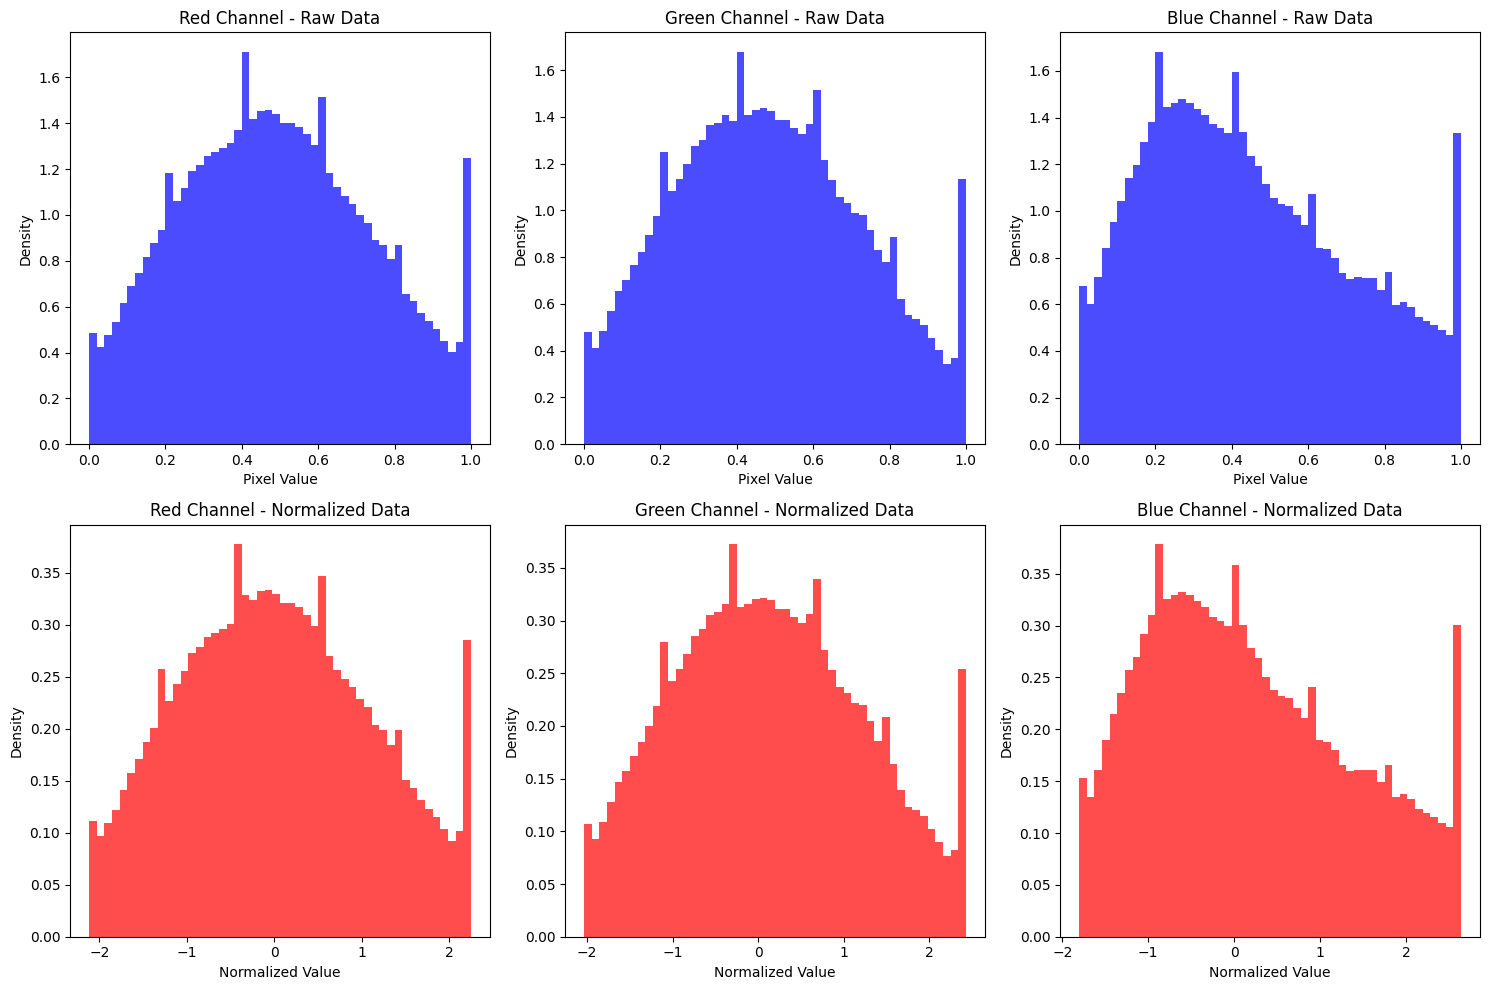

In [9]:
def analyze_normalization_effects():
    """
    정규화 전후 데이터 분포 변화 분석
    """
    # CIFAR-10 데이터셋 로드 (정규화 없음)
    transform_raw = transforms.Compose([
        transforms.ToTensor()
    ])
    
    # CIFAR-10 데이터셋 로드 (정규화 적용)
    # ImageNet 통계값 사용
    transform_normalized = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    
    dataset_raw = torchvision.datasets.CIFAR10(root='./data', train=True,
                                              download=True, transform=transform_raw)
    dataset_norm = torchvision.datasets.CIFAR10(root='./data', train=True,
                                               download=True, transform=transform_normalized)
    
    # 샘플 데이터 수집
    sample_size = 1000
    raw_samples = []
    norm_samples = []
    
    for i in range(sample_size):
        raw_img, _ = dataset_raw[i]
        norm_img, _ = dataset_norm[i]
        
        raw_samples.append(raw_img.numpy())
        norm_samples.append(norm_img.numpy())
    
    raw_data = np.array(raw_samples)
    norm_data = np.array(norm_samples)
    
    # 채널별 통계 계산
    channels = ['Red', 'Green', 'Blue']
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    for c in range(3):
        # 원본 데이터 분포
        axes[0, c].hist(raw_data[:, c, :, :].flatten(), bins=50, alpha=0.7, 
                       label='Raw', color='blue', density=True)
        axes[0, c].set_title(f'{channels[c]} Channel - Raw Data')
        axes[0, c].set_xlabel('Pixel Value')
        axes[0, c].set_ylabel('Density')
        
        # 정규화된 데이터 분포
        axes[1, c].hist(norm_data[:, c, :, :].flatten(), bins=50, alpha=0.7,
                       label='Normalized', color='red', density=True)
        axes[1, c].set_title(f'{channels[c]} Channel - Normalized Data')
        axes[1, c].set_xlabel('Normalized Value')
        axes[1, c].set_ylabel('Density')
        
        # 통계값 출력
        raw_mean = np.mean(raw_data[:, c, :, :])
        raw_std = np.std(raw_data[:, c, :, :])
        norm_mean = np.mean(norm_data[:, c, :, :])
        norm_std = np.std(norm_data[:, c, :, :])
        
        print(f"{channels[c]} Channel:")
        print(f"  Raw - Mean: {raw_mean:.4f}, Std: {raw_std:.4f}")
        print(f"  Normalized - Mean: {norm_mean:.4f}, Std: {norm_std:.4f}")
    
    plt.tight_layout()
    plt.show()
    
    return raw_data, norm_data

# 정규화 효과 분석 실행
raw_data, norm_data = analyze_normalization_effects()

2.2 데이터 증강 기법들과 통계적 검증

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


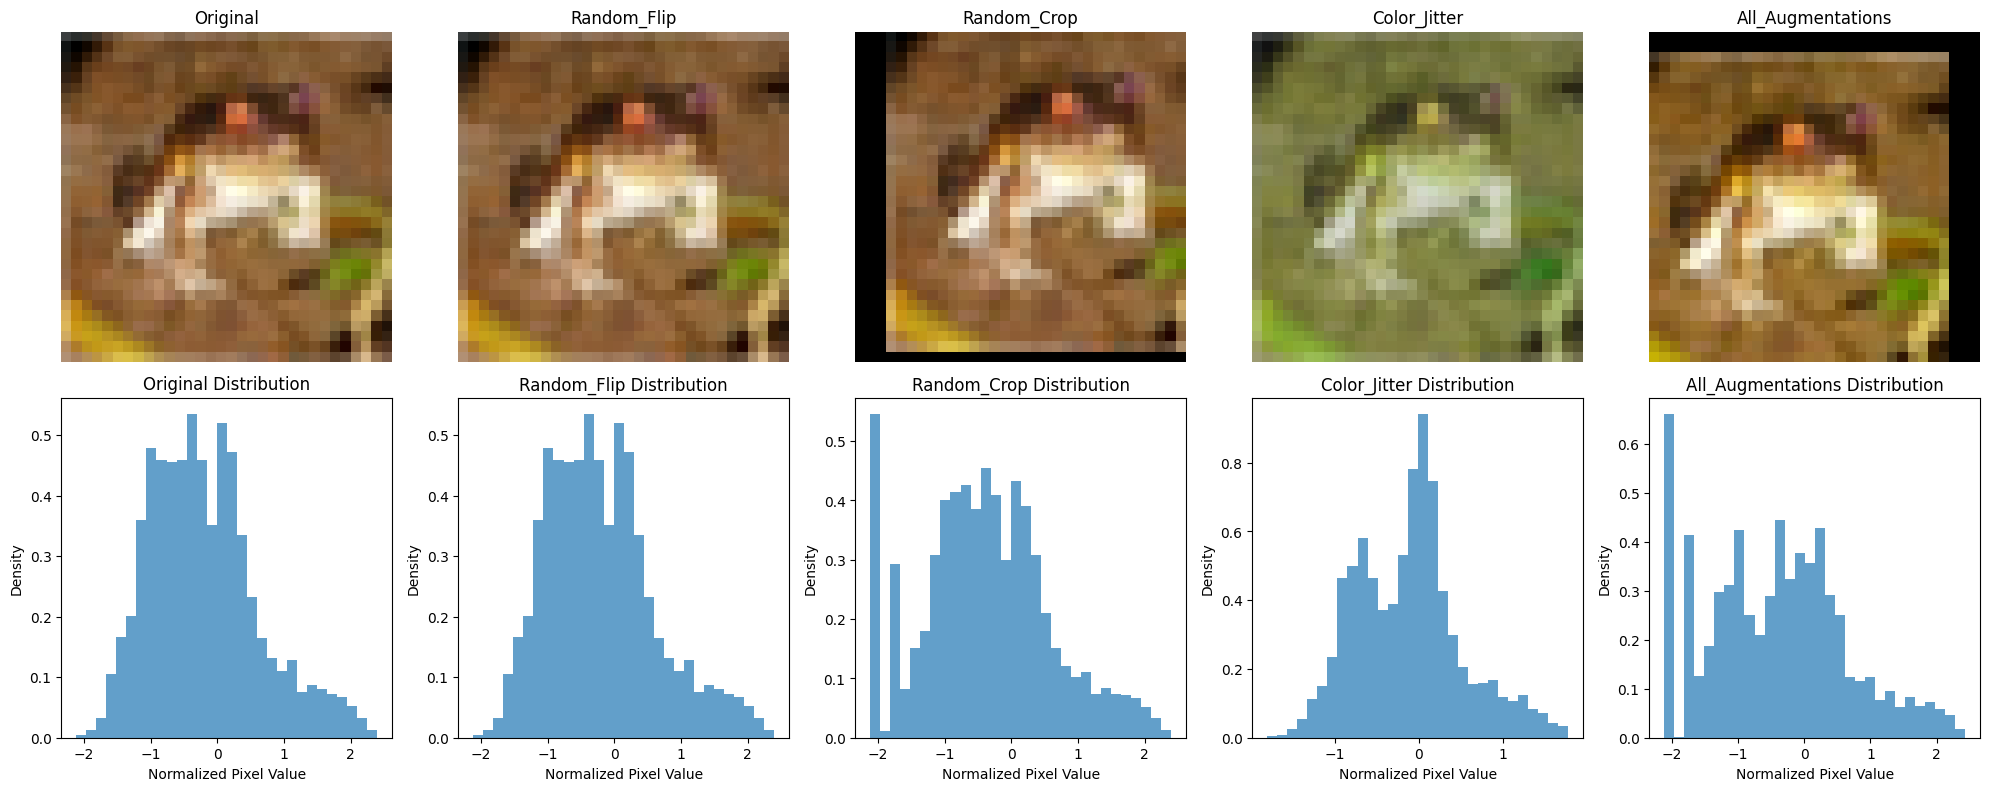

In [11]:
def compare_augmentation_effects():
    """
    다양한 데이터 증강 기법의 효과를 통계적으로 검증
    """
    
    # 다양한 전처리 방법 정의
    transforms_dict = {
        'Original': transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        
        'Random_Flip': transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        
        'Random_Crop': transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        
        'Color_Jitter': transforms.Compose([
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        
        'All_Augmentations': transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomCrop(32, padding=4),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    }
    
    # 각 변환에 대해 데이터 로드
    datasets = {}
    for name, transform in transforms_dict.items():
        datasets[name] = torchvision.datasets.CIFAR10(root='./data', train=True,
                                                     download=True, transform=transform)
    
    # 동일한 이미지에 대해 다른 변환 적용 결과 시각화
    fig, axes = plt.subplots(2, len(transforms_dict), figsize=(20, 8))
    
    # 동일한 인덱스 사용
    idx = 0
    original_img, label = datasets['Original'][idx]
    
    for i, (name, dataset) in enumerate(datasets.items()):
        # 이미지 시각화
        img, _ = dataset[idx]
        
        # 정규화 해제 (시각화를 위해)
        img_denorm = img * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + \
                     torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        img_denorm = torch.clamp(img_denorm, 0, 1)
        
        axes[0, i].imshow(img_denorm.permute(1, 2, 0))
        axes[0, i].set_title(f'{name}')
        axes[0, i].axis('off')
        
        # 픽셀 값 분포 히스토그램
        axes[1, i].hist(img.numpy().flatten(), bins=30, alpha=0.7, density=True)
        axes[1, i].set_title(f'{name} Distribution')
        axes[1, i].set_xlabel('Normalized Pixel Value')
        axes[1, i].set_ylabel('Density')
    
    plt.tight_layout()
    plt.show()
    
    return datasets

datasets = compare_augmentation_effects()

2.3 전처리 방법에 따른 학습 수렴성 비교

Training with No_Normalization...
Files already downloaded and verified
  Epoch 1: Average Loss = 2.2097
  Epoch 2: Average Loss = 2.0272
  Epoch 3: Average Loss = 1.8995
Training with Zero_One_Normalization...
Files already downloaded and verified
  Epoch 1: Average Loss = 2.1520
  Epoch 2: Average Loss = 1.9511
  Epoch 3: Average Loss = 1.8197
Training with ImageNet_Normalization...
Files already downloaded and verified
  Epoch 1: Average Loss = 2.1037
  Epoch 2: Average Loss = 1.8811
  Epoch 3: Average Loss = 1.7708
Training with Dataset_Specific_Normalization...
Files already downloaded and verified
  Epoch 1: Average Loss = 2.1157
  Epoch 2: Average Loss = 1.8932
  Epoch 3: Average Loss = 1.8022


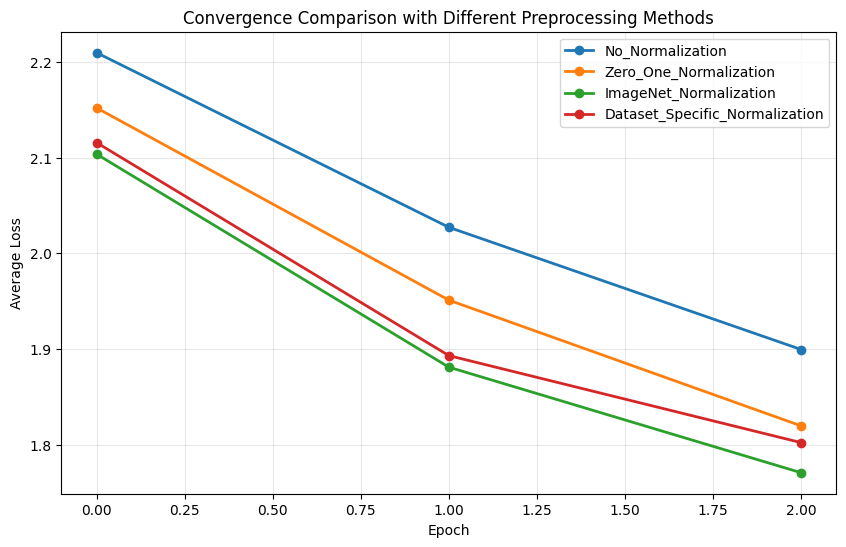

In [13]:
def compare_convergence_with_preprocessing():
    """
    전처리 방법에 따른 학습 수렴성 비교
    """
    
    # 간단한 CNN 모델 정의 (빠른 실험을 위해)
    class SimpleCNN(nn.Module):
        def __init__(self, num_classes=10):
            super(SimpleCNN, self).__init__()
            self.features = nn.Sequential(
                nn.Conv2d(3, 32, 3, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2),
                nn.Conv2d(32, 64, 3, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2),
                nn.Conv2d(64, 128, 3, padding=1),
                nn.ReLU(),
                nn.AdaptiveAvgPool2d((1, 1))
            )
            self.classifier = nn.Linear(128, num_classes)
        
        def forward(self, x):
            x = self.features(x)
            x = torch.flatten(x, 1)
            x = self.classifier(x)
            return x
    
    # 다른 전처리 방법들
    preprocessing_methods = {
        'No_Normalization': transforms.Compose([
            transforms.ToTensor()
        ]),
        
        'Zero_One_Normalization': transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # [0,1] -> [-1,1]
        ]),
        
        'ImageNet_Normalization': transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        
        'Dataset_Specific_Normalization': transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])  # CIFAR-10 통계
        ])
    }
    
    results = {}
    
    for method_name, transform in preprocessing_methods.items():
        print(f"Training with {method_name}...")
        
        # 데이터 로드
        dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                              download=True, transform=transform)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=2)
        
        # 모델 초기화
        model = SimpleCNN()
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        
        # 짧은 훈련 (수렴성 비교용)
        losses = []
        model.train()
        
        for epoch in range(3):  # 3 에포크만 실행
            epoch_loss = 0
            num_batches = 0
            
            for batch_idx, (data, target) in enumerate(dataloader):
                if batch_idx >= 50:  # 50 배치만 실행 (빠른 비교를 위해)
                    break
                    
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
                
                epoch_loss += loss.item()
                num_batches += 1
            
            avg_loss = epoch_loss / num_batches
            losses.append(avg_loss)
            print(f"  Epoch {epoch+1}: Average Loss = {avg_loss:.4f}")
        
        results[method_name] = losses
    
    # 결과 시각화
    plt.figure(figsize=(10, 6))
    for method_name, losses in results.items():
        plt.plot(losses, marker='o', label=method_name, linewidth=2)
    
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.title('Convergence Comparison with Different Preprocessing Methods')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return results

# 전처리 방법별 수렴성 비교 실행
convergence_results = compare_convergence_with_preprocessing()

실습 3: ResNet과 일반 CNN 성능 비교

3.1 그래디언트 흐름 시각화


ResNet-18 Gradient Statistics:
  Mean gradient norm: 22.636266
  Std gradient norm: 36.751540
  Min gradient norm: 0.216097
  Max gradient norm: 221.362915

Deep CNN Gradient Statistics:
  Mean gradient norm: 2.839520
  Std gradient norm: 2.796921
  Min gradient norm: 0.060876
  Max gradient norm: 7.198697


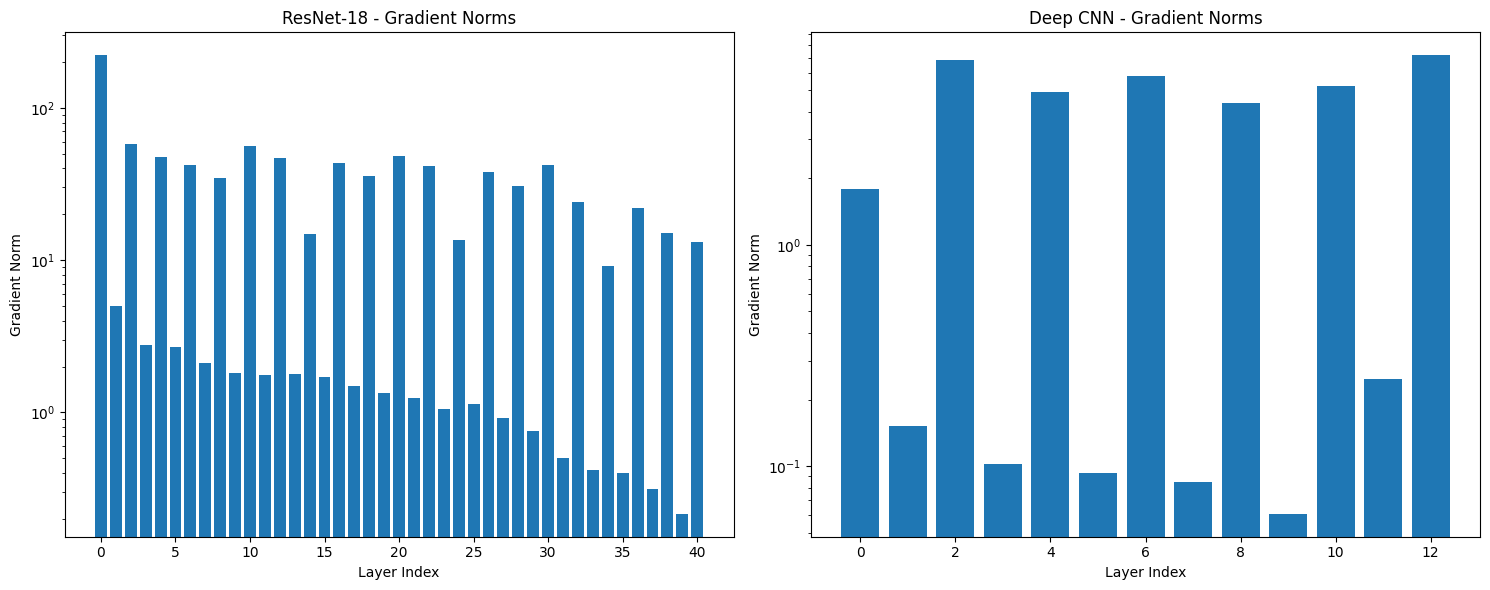

In [15]:
def visualize_gradient_flow():
    """
    ResNet과 일반 CNN의 그래디언트 흐름 비교
    """
    
    # 일반 깊은 CNN (ResNet 없이)
    class DeepCNN(nn.Module):
        def __init__(self, num_classes=10):
            super(DeepCNN, self).__init__()
            self.features = nn.Sequential(
                nn.Conv2d(3, 64, 3, padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(),
                
                nn.Conv2d(64, 64, 3, padding=1),
                nn.BatchNorm2d(64), 
                nn.ReLU(),
                nn.MaxPool2d(2),
                
                nn.Conv2d(64, 128, 3, padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(),
                
                nn.Conv2d(128, 128, 3, padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(),
                nn.MaxPool2d(2),
                
                nn.Conv2d(128, 256, 3, padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(),
                
                nn.Conv2d(256, 256, 3, padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(),
                nn.MaxPool2d(2),
                
                nn.AdaptiveAvgPool2d((1, 1))
            )
            self.classifier = nn.Linear(256, num_classes)
        
        def forward(self, x):
            x = self.features(x)
            x = torch.flatten(x, 1)
            x = self.classifier(x)
            return x
    
    # 모델 생성 및 GPU 이동
    resnet_model = ResNet18(num_classes=10).to(device)
    cnn_model = DeepCNN(num_classes=10).to(device)
    
    # 더미 데이터와 타겟 (GPU로 이동)
    x = torch.randn(4, 3, 32, 32, requires_grad=True).to(device)
    target = torch.randint(0, 10, (4,)).to(device)
    
    models = {'ResNet-18': resnet_model, 'Deep CNN': cnn_model}
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    for idx, (model_name, model) in enumerate(models.items()):
        # Forward pass
        output = model(x)
        loss = F.cross_entropy(output, target)
        
        # Backward pass
        loss.backward(retain_graph=True)
        
        # 각 층의 그래디언트 수집
        layer_names = []
        grad_norms = []
        
        for name, param in model.named_parameters():
            if param.grad is not None and 'weight' in name:
                layer_names.append(name.split('.')[0])  # 층 이름만 추출
                grad_norms.append(param.grad.norm().item())
        
        # 시각화
        axes[idx].bar(range(len(grad_norms)), grad_norms)
        axes[idx].set_title(f'{model_name} - Gradient Norms')
        axes[idx].set_xlabel('Layer Index')
        axes[idx].set_ylabel('Gradient Norm')
        axes[idx].set_yscale('log')  # 로그 스케일로 표시
        
        # 통계 출력
        print(f"\n{model_name} Gradient Statistics:")
        print(f"  Mean gradient norm: {np.mean(grad_norms):.6f}")
        print(f"  Std gradient norm: {np.std(grad_norms):.6f}")
        print(f"  Min gradient norm: {np.min(grad_norms):.6f}")
        print(f"  Max gradient norm: {np.max(grad_norms):.6f}")
        
        # 그래디언트 초기화
        model.zero_grad()
    
    plt.tight_layout()
    plt.show()

visualize_gradient_flow()

3.2 학습 곡선 비교

Files already downloaded and verified
Files already downloaded and verified

Training ResNet-18...
  Epoch 1: Train Loss: 1.7060, Train Acc: 38.13%, Test Acc: 43.55%
  Epoch 2: Train Loss: 1.3834, Train Acc: 50.38%, Test Acc: 53.52%
  Epoch 3: Train Loss: 1.2202, Train Acc: 55.94%, Test Acc: 54.88%
  Epoch 4: Train Loss: 1.1179, Train Acc: 60.53%, Test Acc: 58.16%
  Epoch 5: Train Loss: 1.0224, Train Acc: 63.50%, Test Acc: 59.38%

Training Deep CNN...
  Epoch 1: Train Loss: 1.5421, Train Acc: 42.74%, Test Acc: 42.42%
  Epoch 2: Train Loss: 1.1535, Train Acc: 58.44%, Test Acc: 49.14%
  Epoch 3: Train Loss: 0.9980, Train Acc: 64.59%, Test Acc: 53.55%
  Epoch 4: Train Loss: 0.9051, Train Acc: 67.82%, Test Acc: 63.36%
  Epoch 5: Train Loss: 0.8205, Train Acc: 71.36%, Test Acc: 67.93%


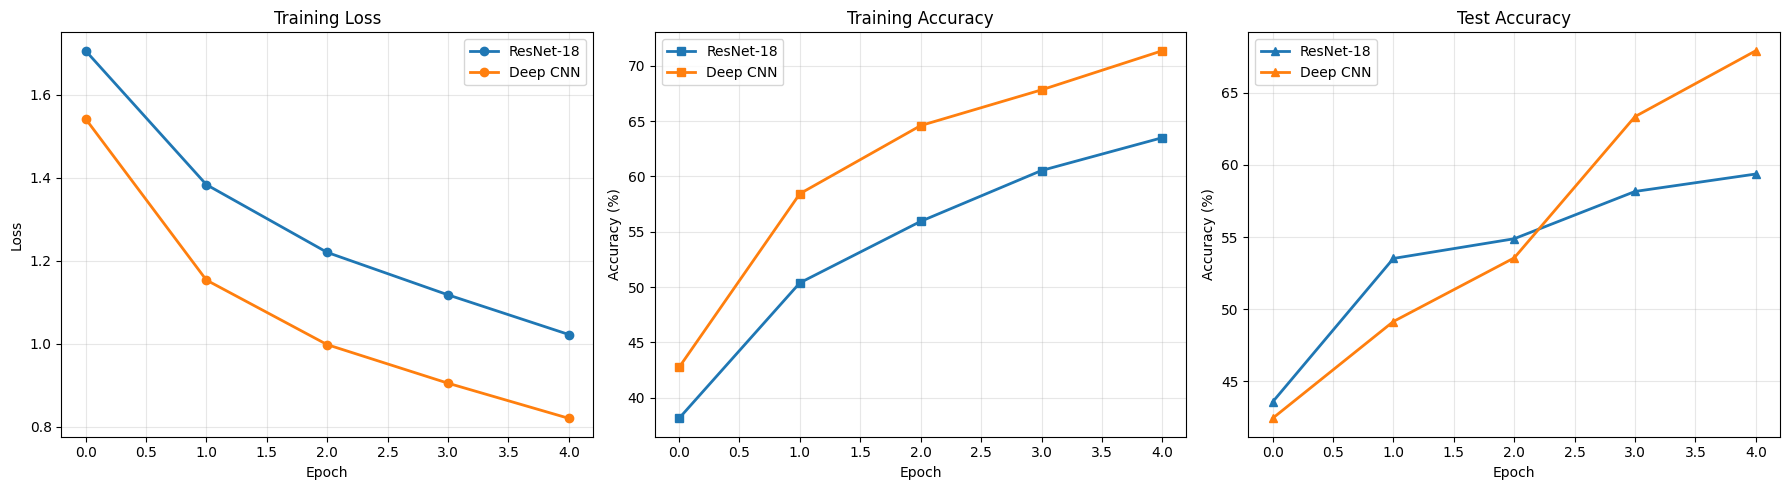

In [17]:
def compare_learning_curves():
    """
    ResNet과 일반 CNN의 학습 곡선 비교
    """
    
    # 데이터 준비
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
    ])
    
    train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                                download=True, transform=transform)
    test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                               download=True, transform=transform)
    
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2, pin_memory=True)
    
    # 모델들 정의
    class DeepCNN(nn.Module):
        def __init__(self, num_classes=10):
            super(DeepCNN, self).__init__()
            self.features = nn.Sequential(
                nn.Conv2d(3, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
                nn.Conv2d(64, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
                nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
                nn.Conv2d(128, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2),
                nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
                nn.Conv2d(256, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(), nn.MaxPool2d(2),
                nn.AdaptiveAvgPool2d((1, 1))
            )
            self.classifier = nn.Linear(256, num_classes)
        
        def forward(self, x):
            x = self.features(x)
            x = torch.flatten(x, 1)
            x = self.classifier(x)
            return x
    
    models = {
        'ResNet-18': ResNet18(num_classes=10),
        'Deep CNN': DeepCNN(num_classes=10)
    }
    
    # 각 모델 훈련
    results = {}
    
    for model_name, model in models.items():
        print(f"\nTraining {model_name}...")
        
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
        
        train_losses = []
        train_accs = []
        test_accs = []
        
        # 간단한 훈련 (5 에포크)
        for epoch in range(5):
            # 훈련
            model.train()
            train_loss = 0
            train_correct = 0
            train_total = 0
            
            for batch_idx, (data, target) in enumerate(train_loader):
                if batch_idx >= 100:  # 빠른 실습을 위해 제한
                    break
                    
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item()
                _, predicted = output.max(1)
                train_total += target.size(0)
                train_correct += predicted.eq(target).sum().item()
            
            # 테스트
            model.eval()
            test_correct = 0
            test_total = 0
            
            with torch.no_grad():
                for batch_idx, (data, target) in enumerate(test_loader):
                    if batch_idx >= 20:  # 빠른 실습을 위해 제한
                        break
                        
                    output = model(data)
                    _, predicted = output.max(1)
                    test_total += target.size(0)
                    test_correct += predicted.eq(target).sum().item()
            
            train_acc = 100. * train_correct / train_total
            test_acc = 100. * test_correct / test_total
            avg_train_loss = train_loss / min(100, len(train_loader))
            
            train_losses.append(avg_train_loss)
            train_accs.append(train_acc)
            test_accs.append(test_acc)
            
            scheduler.step()
            
            print(f'  Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, '
                  f'Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%')
        
        results[model_name] = {
            'train_losses': train_losses,
            'train_accs': train_accs,
            'test_accs': test_accs
        }
    
    # 결과 시각화
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # 훈련 손실
    for model_name, data in results.items():
        axes[0].plot(data['train_losses'], marker='o', label=model_name, linewidth=2)
    axes[0].set_title('Training Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # 훈련 정확도
    for model_name, data in results.items():
        axes[1].plot(data['train_accs'], marker='s', label=model_name, linewidth=2)
    axes[1].set_title('Training Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # 테스트 정확도
    for model_name, data in results.items():
        axes[2].plot(data['test_accs'], marker='^', label=model_name, linewidth=2)
    axes[2].set_title('Test Accuracy')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Accuracy (%)')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return results

# 학습 곡선 비교 실행 (시간이 오래 걸릴 수 있습니다)
learning_results = compare_learning_curves()

실습 4: 데이터 전처리의 통계적 검증

4.1 전처리 방법의 통계적 유의성 검정


Testing No_Normalization: Raw pixel values [0, 1]
  Run 1/3
Files already downloaded and verified
Files already downloaded and verified
    Accuracy: 42.40%
  Run 2/3
Files already downloaded and verified
Files already downloaded and verified
    Accuracy: 40.60%
  Run 3/3
Files already downloaded and verified
Files already downloaded and verified
    Accuracy: 40.70%

Testing Standard_Normalization: Normalized to [-1, 1]
  Run 1/3
Files already downloaded and verified
Files already downloaded and verified
    Accuracy: 47.20%
  Run 2/3
Files already downloaded and verified
Files already downloaded and verified
    Accuracy: 46.40%
  Run 3/3
Files already downloaded and verified
Files already downloaded and verified
    Accuracy: 47.30%

Testing CIFAR10_Normalization: CIFAR-10 dataset statistics
  Run 1/3
Files already downloaded and verified
Files already downloaded and verified
    Accuracy: 50.80%
  Run 2/3
Files already downloaded and verified
Files already downloaded and verified

C:\Users\JPJ\AppData\Local\Temp\ipykernel_19044\3372658295.py:165: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax1.boxplot(box_data, labels=[name.replace('_', '\n') for name in config_names])


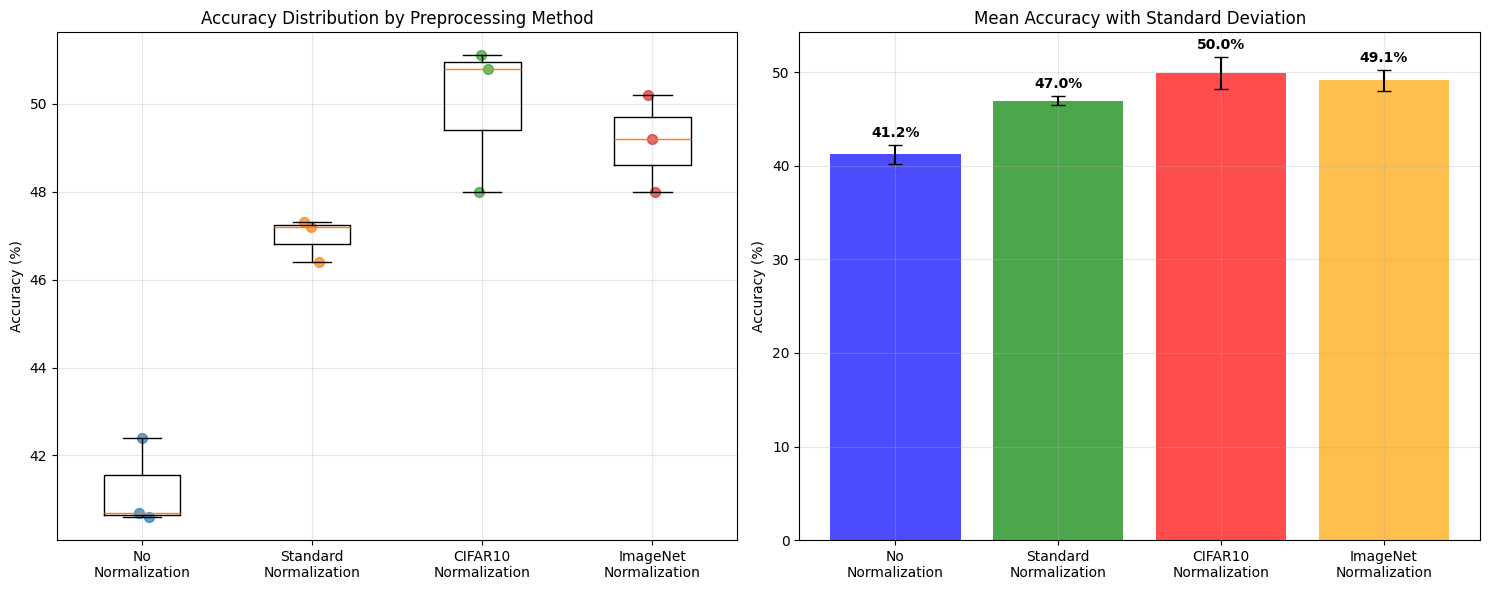

In [18]:
def statistical_significance_test():
    """
    다양한 전처리 방법의 성능 차이에 대한 통계적 유의성 검정
    """
    
    # 간단한 모델 정의 (빠른 실험용)
    class SimpleNet(nn.Module):
        def __init__(self):
            super(SimpleNet, self).__init__()
            self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
            self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
            self.pool = nn.MaxPool2d(2)
            self.fc1 = nn.Linear(64 * 8 * 8, 128)
            self.fc2 = nn.Linear(128, 10)
            self.dropout = nn.Dropout(0.5)
        
        def forward(self, x):
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            x = x.view(x.size(0), -1)
            x = F.relu(self.fc1(x))
            x = self.dropout(x)
            x = self.fc2(x)
            return x
    
    # 전처리 방법들
    preprocessing_configs = {
        'No_Normalization': {
            'transform': transforms.Compose([transforms.ToTensor()]),
            'description': 'Raw pixel values [0, 1]'
        },
        'Standard_Normalization': {
            'transform': transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
            ]),
            'description': 'Normalized to [-1, 1]'
        },
        'CIFAR10_Normalization': {
            'transform': transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
            ]),
            'description': 'CIFAR-10 dataset statistics'
        },
        'ImageNet_Normalization': {
            'transform': transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]),
            'description': 'ImageNet dataset statistics'
        }
    }
    
    # 각 전처리 방법에 대해 여러 번 실험 수행
    n_runs = 3  # 실제로는 더 많이 해야 하지만, 실습용으로는 3번
    results = {config: [] for config in preprocessing_configs.keys()}
    
    for config_name, config in preprocessing_configs.items():
        print(f"\nTesting {config_name}: {config['description']}")
        
        for run in range(n_runs):
            print(f"  Run {run + 1}/{n_runs}")
            
            # 데이터 로드
            train_dataset = torchvision.datasets.CIFAR10(
                root='./data', train=True, download=True, transform=config['transform']
            )
            test_dataset = torchvision.datasets.CIFAR10(
                root='./data', train=False, download=True, transform=config['transform']
            )
            
            # 데이터 로더 (작은 subset 사용, GPU 최적화)
            train_subset = torch.utils.data.Subset(train_dataset, range(0, 5000))  # 5000개만 사용
            test_subset = torch.utils.data.Subset(test_dataset, range(0, 1000))    # 1000개만 사용
            
            train_loader = DataLoader(train_subset, batch_size=64, shuffle=True, pin_memory=True)
            test_loader = DataLoader(test_subset, batch_size=64, shuffle=False, pin_memory=True)
            
            # 모델 초기화 및 GPU 이동
            model = SimpleNet().to(device)
            criterion = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
            
            # 간단한 훈련 (3 에포크)
            model.train()
            for epoch in range(3):
                for batch_idx, (data, target) in enumerate(train_loader):
                    # GPU로 데이터 이동
                    data, target = data.to(device), target.to(device)
                    
                    optimizer.zero_grad()
                    output = model(data)
                    loss = criterion(output, target)
                    loss.backward()
                    optimizer.step()
            
            # 테스트
            model.eval()
            correct = 0
            total = 0
            
            with torch.no_grad():
                for data, target in test_loader:
                    # GPU로 데이터 이동
                    data, target = data.to(device), target.to(device)
                    
                    output = model(data)
                    _, predicted = output.max(1)
                    total += target.size(0)
                    correct += predicted.eq(target).sum().item()
            
            accuracy = 100. * correct / total
            results[config_name].append(accuracy)
            print(f"    Accuracy: {accuracy:.2f}%")
    
    # 통계적 분석
    print("\n" + "="*60)
    print("STATISTICAL ANALYSIS RESULTS")
    print("="*60)
    
    # 기술 통계
    stats_summary = {}
    for config_name, accuracies in results.items():
        mean_acc = np.mean(accuracies)
        std_acc = np.std(accuracies, ddof=1)  # 표본 표준편차
        stats_summary[config_name] = {'mean': mean_acc, 'std': std_acc, 'values': accuracies}
        
        print(f"\n{config_name}:")
        print(f"  Mean Accuracy: {mean_acc:.3f}% ± {std_acc:.3f}%")
        print(f"  Individual runs: {[f'{acc:.2f}%' for acc in accuracies]}")
    
    # 쌍별 t-검정 (Pairwise t-tests)
    from itertools import combinations
    
    print(f"\nPairwise t-tests (α = 0.05):")
    print("-" * 40)
    
    config_names = list(results.keys())
    for config1, config2 in combinations(config_names, 2):
        values1 = results[config1]
        values2 = results[config2]
        
        # 대응 표본 t-검정 (같은 데이터셋으로 비교했으므로)
        t_stat, p_value = stats.ttest_rel(values1, values2)
        
        significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
        
        print(f"{config1} vs {config2}:")
        print(f"  t-statistic: {t_stat:.4f}")
        print(f"  p-value: {p_value:.4f} {significance}")
        
        if p_value < 0.05:
            better = config1 if np.mean(values1) > np.mean(values2) else config2
            print(f"  Result: {better} is significantly better")
        else:
            print(f"  Result: No significant difference")
        print()
    
    # 결과 시각화
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Box plot
    box_data = [results[config] for config in config_names]
    box = ax1.boxplot(box_data, labels=[name.replace('_', '\n') for name in config_names])
    ax1.set_title('Accuracy Distribution by Preprocessing Method')
    ax1.set_ylabel('Accuracy (%)')
    ax1.grid(True, alpha=0.3)
    
    # 개별 데이터 점들도 표시
    for i, config_name in enumerate(config_names):
        y = results[config_name]
        x = np.random.normal(i+1, 0.04, size=len(y))
        ax1.scatter(x, y, alpha=0.7, s=50)
    
    # Bar plot with error bars
    means = [stats_summary[config]['mean'] for config in config_names]
    stds = [stats_summary[config]['std'] for config in config_names]
    
    bars = ax2.bar(range(len(config_names)), means, yerr=stds, capsize=5, 
                   alpha=0.7, color=['blue', 'green', 'red', 'orange'])
    ax2.set_title('Mean Accuracy with Standard Deviation')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_xticks(range(len(config_names)))
    ax2.set_xticklabels([name.replace('_', '\n') for name in config_names])
    ax2.grid(True, alpha=0.3)
    
    # 막대 위에 정확한 수치 표시
    for i, (bar, mean, std) in enumerate(zip(bars, means, stds)):
        ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height() + std + 0.5,
                f'{mean:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    return results, stats_summary

# 통계적 유의성 검정 실행
results, stats = statistical_significance_test()

4.2 데이터 분포 분석과 이상치 탐지

Files already downloaded and verified
CIFAR-10 Dataset Analysis
Sample size: 5,000
Image shape: (3, 32, 32)
Data type: float32

Channel-wise Statistics:

  Red Channel:
    Mean: 0.4913
    Std:  0.2476
    Median: 0.4824
    IQR: [0.3020, 0.6706]

  Green Channel:
    Mean: 0.4814
    Std:  0.2445
    Median: 0.4706
    IQR: [0.2941, 0.6549]

  Blue Channel:
    Mean: 0.4445
    Std:  0.2627
    Median: 0.4078
    IQR: [0.2314, 0.6353]


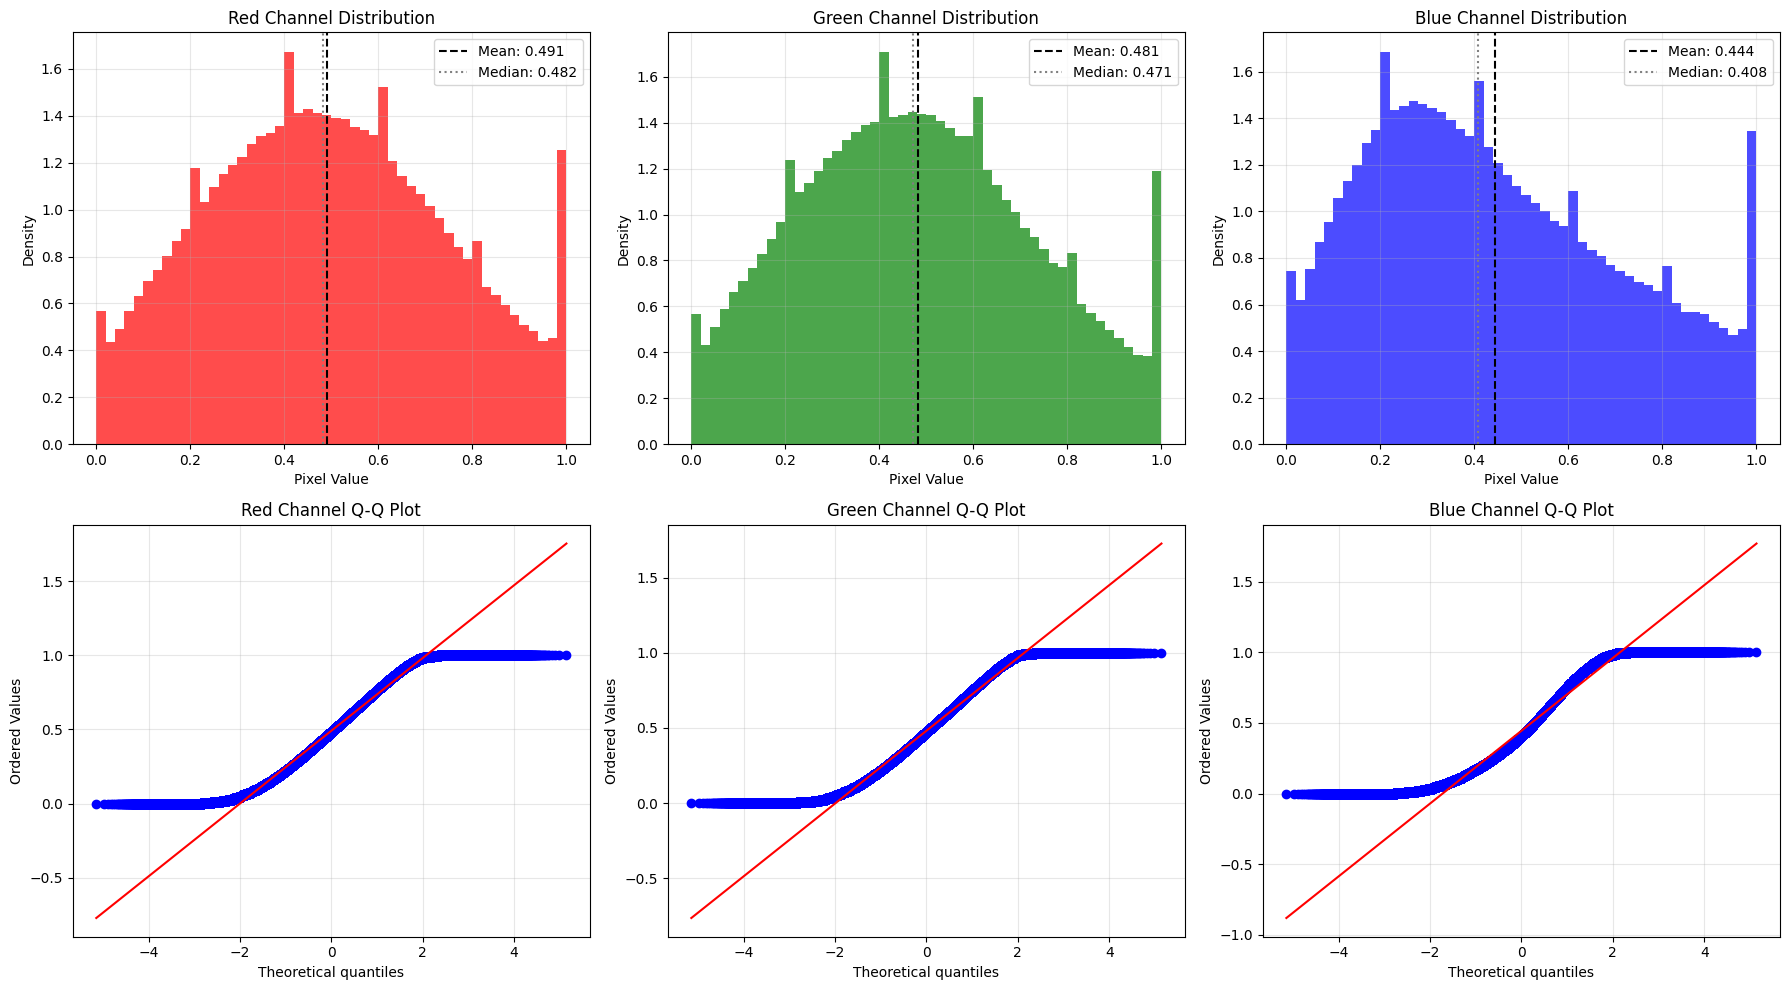


Class-wise Analysis:
------------------------------
    airplane: Count=505, Brightness=0.559±0.143
  automobile: Count=460, Brightness=0.456±0.116
        bird: Count=519, Brightness=0.468±0.136
         cat: Count=486, Brightness=0.456±0.126
        deer: Count=519, Brightness=0.431±0.107
         dog: Count=488, Brightness=0.455±0.107
        frog: Count=519, Brightness=0.413±0.120
       horse: Count=486, Brightness=0.463±0.104
        ship: Count=520, Brightness=0.529±0.109
       truck: Count=498, Brightness=0.492±0.100


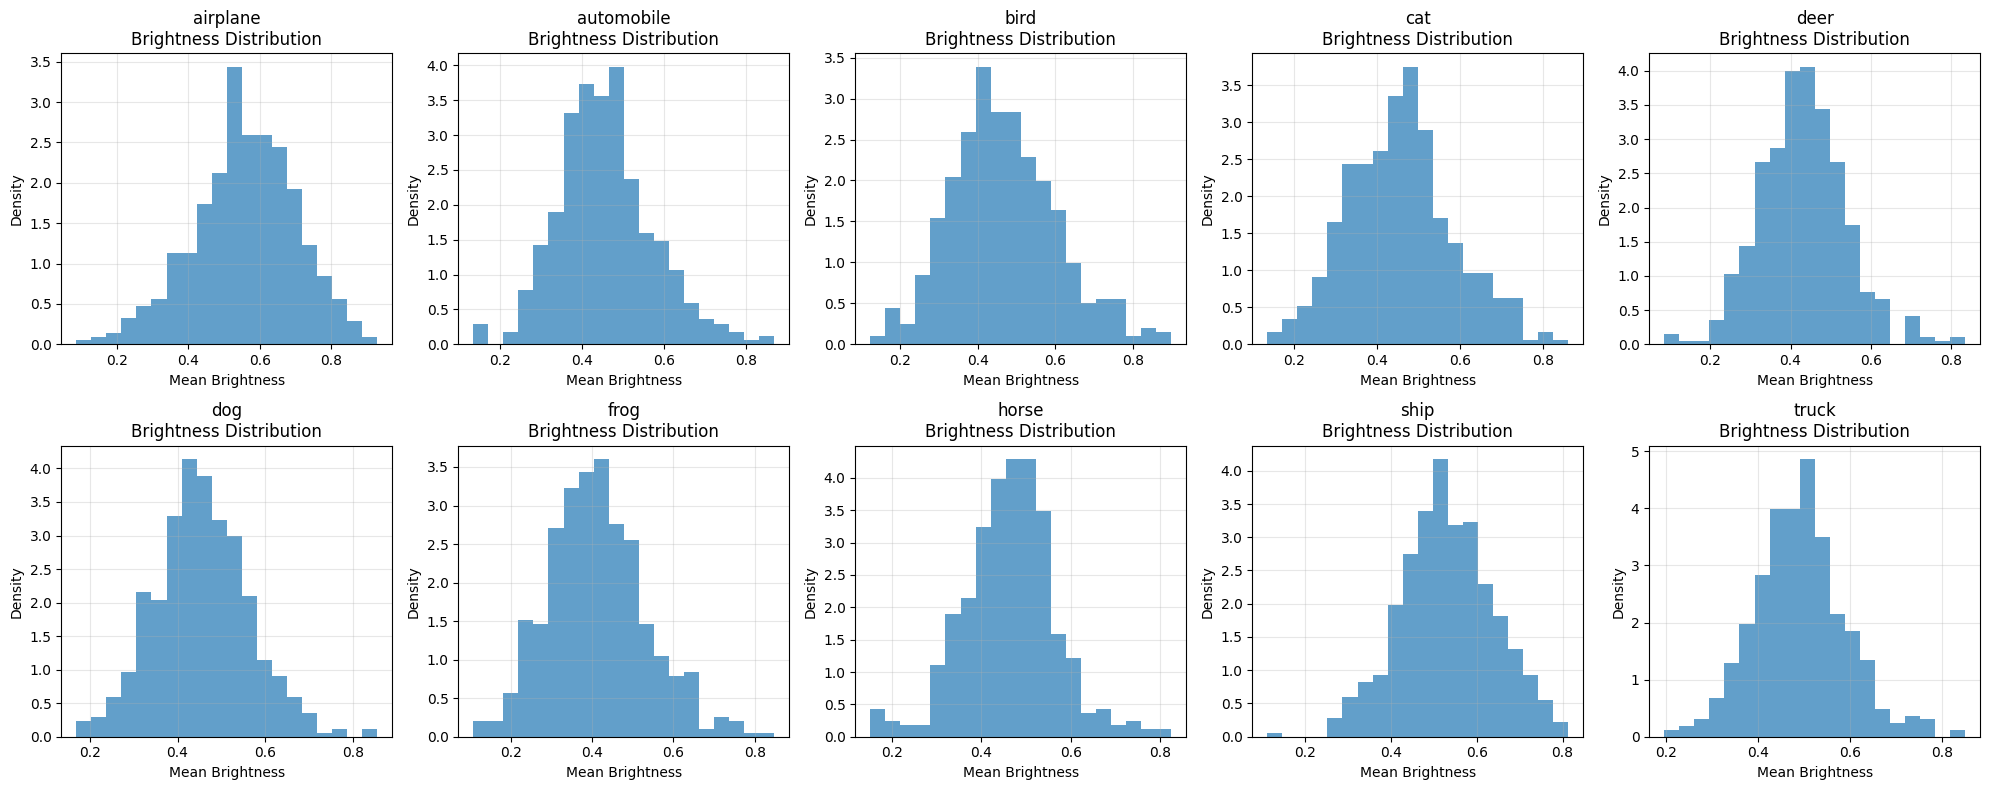


Outlier Detection:
--------------------
IQR Outlier Detection:
  Q1: 0.3892
  Q3: 0.5464
  IQR: 0.1573
  Lower bound: 0.1532
  Upper bound: 0.7823
  Number of outliers: 74 (1.48%)

Z-score Outlier Detection (|z| > 3):
  Number of outliers: 18 (0.36%)


C:\Users\JPJ\AppData\Local\Temp\ipykernel_19044\2383833591.py:153: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax1.boxplot([all_brightness], labels=['All Images'])


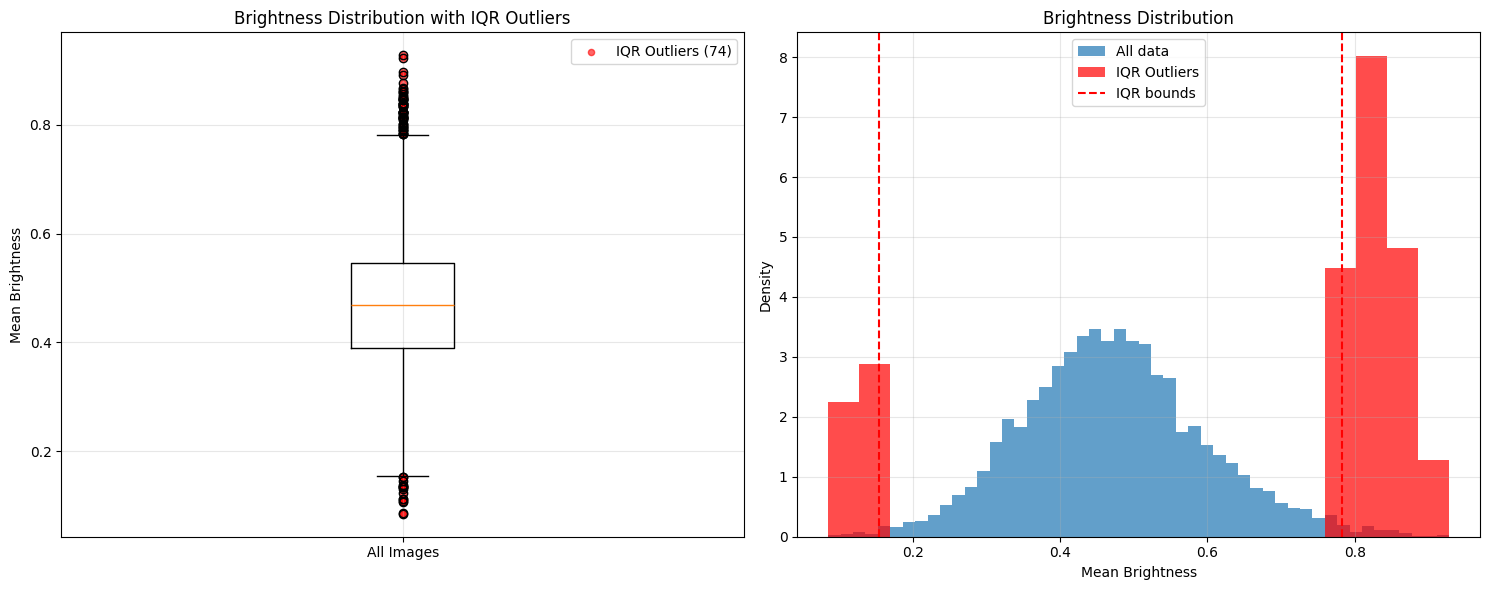


Normality Tests:
---------------
Shapiro-Wilk test (n=5000):
  Statistic: 0.995071
  p-value: 5.20e-12
  Result: Not normal (α=0.05)

D'Agostino's normality test:
  Statistic: 64.117419
  p-value: 1.19e-14
  Result: Not normal (α=0.05)


In [24]:
def analyze_data_distribution():
    """
    CIFAR-10 데이터의 분포 특성 분석 및 이상치 탐지
    """
    
    # 원본 데이터 로드
    transform = transforms.Compose([transforms.ToTensor()])
    dataset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                          download=True, transform=transform)
    
    # 샘플 데이터 수집
    sample_size = 5000
    pixel_values = []
    class_labels = []
    
    for i in range(sample_size):
        img, label = dataset[i]
        pixel_values.append(img.numpy())
        class_labels.append(label)
    
    pixel_data = np.array(pixel_values)
    class_data = np.array(class_labels)
    
    # CIFAR-10 클래스 이름
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
                   'dog', 'frog', 'horse', 'ship', 'truck']
    
    print("CIFAR-10 Dataset Analysis")
    print("=" * 50)
    
    # 전체 데이터 통계
    print(f"Sample size: {sample_size:,}")
    print(f"Image shape: {pixel_data.shape[1:]}")
    print(f"Data type: {pixel_data.dtype}")
    
    # 채널별 통계 분석
    print(f"\nChannel-wise Statistics:")
    channels = ['Red', 'Green', 'Blue']
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    for c in range(3):
        channel_data = pixel_data[:, c, :, :].flatten()
        
        # 기본 통계
        mean_val = np.mean(channel_data)
        std_val = np.std(channel_data)
        median_val = np.median(channel_data)
        q25, q75 = np.percentile(channel_data, [25, 75])
        
        print(f"\n  {channels[c]} Channel:")
        print(f"    Mean: {mean_val:.4f}")
        print(f"    Std:  {std_val:.4f}")
        print(f"    Median: {median_val:.4f}")
        print(f"    IQR: [{q25:.4f}, {q75:.4f}]")
        
        # 히스토그램
        axes[0, c].hist(channel_data, bins=50, density=True, alpha=0.7, 
                       color=['red', 'green', 'blue'][c])
        axes[0, c].axvline(mean_val, color='black', linestyle='--', label=f'Mean: {mean_val:.3f}')
        axes[0, c].axvline(median_val, color='gray', linestyle=':', label=f'Median: {median_val:.3f}')
        axes[0, c].set_title(f'{channels[c]} Channel Distribution')
        axes[0, c].set_xlabel('Pixel Value')
        axes[0, c].set_ylabel('Density')
        axes[0, c].legend()
        axes[0, c].grid(True, alpha=0.3)
        
        from scipy.stats import probplot
        # Q-Q plot (정규성 검정)
        probplot(channel_data, dist="norm", plot=axes[1, c])
        axes[1, c].set_title(f'{channels[c]} Channel Q-Q Plot')
        axes[1, c].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 클래스별 분석
    print(f"\nClass-wise Analysis:")
    print("-" * 30)
    
    class_stats = {}
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.flatten()
    
    for class_idx in range(10):
        # 해당 클래스의 이미지들만 선택
        class_mask = class_data == class_idx
        class_images = pixel_data[class_mask]
        
        # 밝기 계산 (RGB의 평균)
        brightness = np.mean(class_images, axis=(1, 2, 3))
        
        mean_brightness = np.mean(brightness)
        std_brightness = np.std(brightness)
        
        class_stats[class_idx] = {
            'mean_brightness': mean_brightness,
            'std_brightness': std_brightness,
            'count': np.sum(class_mask)
        }
        
        print(f"  {class_names[class_idx]:>10}: "
              f"Count={np.sum(class_mask):>3}, "
              f"Brightness={mean_brightness:.3f}±{std_brightness:.3f}")
        
        # 밝기 분포 히스토그램
        axes[class_idx].hist(brightness, bins=20, alpha=0.7, density=True)
        axes[class_idx].set_title(f'{class_names[class_idx]}\nBrightness Distribution')
        axes[class_idx].set_xlabel('Mean Brightness')
        axes[class_idx].set_ylabel('Density')
        axes[class_idx].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 이상치 탐지
    print(f"\nOutlier Detection:")
    print("-" * 20)
    
    # IQR 방법으로 이상치 탐지
    all_brightness = np.mean(pixel_data, axis=(1, 2, 3))
    Q1 = np.percentile(all_brightness, 25)
    Q3 = np.percentile(all_brightness, 75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = (all_brightness < lower_bound) | (all_brightness > upper_bound)
    n_outliers = np.sum(outliers)
    
    print(f"IQR Outlier Detection:")
    print(f"  Q1: {Q1:.4f}")
    print(f"  Q3: {Q3:.4f}")
    print(f"  IQR: {IQR:.4f}")
    print(f"  Lower bound: {lower_bound:.4f}")
    print(f"  Upper bound: {upper_bound:.4f}")
    print(f"  Number of outliers: {n_outliers} ({100*n_outliers/sample_size:.2f}%)")
    
    # Z-score 방법
    from scipy.stats import zscore
    z_scores = np.abs(zscore(all_brightness))
    z_outliers = z_scores > 3
    n_z_outliers = np.sum(z_outliers)
    
    print(f"\nZ-score Outlier Detection (|z| > 3):")
    print(f"  Number of outliers: {n_z_outliers} ({100*n_z_outliers/sample_size:.2f}%)")
    
    # 이상치 시각화
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Box plot
    ax1.boxplot([all_brightness], labels=['All Images'])
    ax1.scatter([1] * len(all_brightness[outliers]), all_brightness[outliers], 
               color='red', alpha=0.6, s=20, label=f'IQR Outliers ({n_outliers})')
    ax1.set_title('Brightness Distribution with IQR Outliers')
    ax1.set_ylabel('Mean Brightness')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 히스토그램
    ax2.hist(all_brightness, bins=50, alpha=0.7, density=True, label='All data')
    ax2.hist(all_brightness[outliers], bins=20, alpha=0.7, color='red', 
            density=True, label=f'IQR Outliers')
    ax2.axvline(lower_bound, color='red', linestyle='--', label='IQR bounds')
    ax2.axvline(upper_bound, color='red', linestyle='--')
    ax2.set_title('Brightness Distribution')
    ax2.set_xlabel('Mean Brightness')
    ax2.set_ylabel('Density')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 정규성 검정
    from scipy.stats import shapiro, normaltest
    
    print(f"\nNormality Tests:")
    print("-" * 15)
    
    # Shapiro-Wilk test (샘플이 많으면 부분만)
    sample_for_test = all_brightness[:5000] if len(all_brightness) > 5000 else all_brightness
    shapiro_stat, shapiro_p = shapiro(sample_for_test)
    
    # D'Agostino's normality test
    dagostino_stat, dagostino_p = normaltest(all_brightness)
    
    print(f"Shapiro-Wilk test (n={len(sample_for_test)}):")
    print(f"  Statistic: {shapiro_stat:.6f}")
    print(f"  p-value: {shapiro_p:.2e}")
    print(f"  Result: {'Normal' if shapiro_p > 0.05 else 'Not normal'} (α=0.05)")
    
    print(f"\nD'Agostino's normality test:")
    print(f"  Statistic: {dagostino_stat:.6f}")
    print(f"  p-value: {dagostino_p:.2e}")
    print(f"  Result: {'Normal' if dagostino_p > 0.05 else 'Not normal'} (α=0.05)")
    
    return {
        'pixel_data': pixel_data,
        'class_data': class_data,
        'class_stats': class_stats,
        'outliers': outliers,
        'brightness': all_brightness
    }

# 데이터 분포 분석 실행
data_analysis = analyze_data_distribution()